In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
NUM_HISTORY = 6
TESTING_GRAD_NORMS = 1
if 0:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 1
    REWARD_MULT = 1
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 2
    REWARD_MULT = 4
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]

N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 1
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
ADV_ENABLED = True


def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

def MLP(x, lshapes, output_units, name_fcn, is_train):
    h = [x]
    h.append(tf.nn.leaky_relu(tf.layers.dense(h[-1], lshapes[0], name=name_fcn())))
    init = 0
    for size in lshapes:
        if not init:
            init = 1
            h2 = h[-1]
        h.append(tf.nn.leaky_relu(h[-1] + tf.layers.dense(
            h2, size, name=name_fcn(),
            kernel_initializer = tf.keras.initializers.Orthogonal(gain=0.01))
        ))
        #h[-1] = tf.layers.batch_normalization(h[-1], momentum = .9, training = is_train)
        h2 = tf.concat((h[-1], x), -1)
    hout = tf.concat((h[len(h)//2:]), -1)
    output = tf.layers.dense(
        hout, output_units, name=name_fcn(), 
        kernel_initializer = tf.keras.initializers.Orthogonal(gain=0.01),
        bias_initializer = tf.keras.initializers.zeros())
    #output = tf.layers.batch_normalization(output, momentum = .9, training = is_train)
    if output_units == 1:
        output = tf.squeeze(output, -1)
    return h, output
class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [128 * SIZE_MULT] * 16, config = None, 
                 lshapes_small = [64 * SIZE_MULT] * 16):
        self.a_idx = 0
        self.c_idx = 0
        self.v_idx = 0
        self.sess = tf.InteractiveSession(config=config)
        self.obs = tf.placeholder(tf.float32, (None, None, INPUT_UNITS))
        self.metaobs = tf.placeholder(tf.float32, (None, None, 1))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))

        self.is_train = tf.placeholder_with_default(True, (None))

        
        self.actions_input = tf.concat((self.obs, self.metaobs), axis=-1)
        self.actions_input = tf.nn.tanh(self.actions_input*100) / 10 + tf.nn.tanh(
            self.actions_input) + self.actions_input * .1
        self.h, self.pi = MLP(
            self.actions_input, lshapes, N_ACT, self.a_name, self.is_train)
        self.pi = tf.nn.tanh(
            self.pi)/5 + tf.nn.tanh(self.pi/5)/2 + tf.nn.tanh(
            self.pi/100) + self.pi * 1e-3
        if len(self.pi.shape) == 2:
            self.pi = tf.expand_dims(self.pi, -1)
        self.hs, self.state_value_estimate = MLP(
            self.actions_input, lshapes_small, 1, self.v_name, self.is_train)
        self.critic_input = tf.concat((self.actions_input, self.pi), -1)
        
        self.advantage = ((
            self.state_value_estimate[:,1:] * GAMMA + self.returns) -
            self.state_value_estimate[:,:-1])
        
        self.hae, self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, self.c_name, self.is_train)
        
        self.t_vars = tf.trainable_variables()
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        
        self.creg, self.areg, self.vreg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e0
            for optvars in [self.c_vars, self.a_vars, self.v_vars]]
#         self.diff_actions = self.pi[:,1:,:] - self.pi[:,:-1,:]
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        self.actionmean = tf.reduce_sum(
            self.pi[:,:-1,:] * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1)
        self.actdiffsquared = tf.square(
            self.pi[:,:-1,:] - tf.expand_dims(self.actionmean, 1))
        self.actvar = tf.reduce_sum(
            self.actdiffsquared * self.maskexpanded, 1)/ tf.reduce_sum(
            self.maskexpanded, 1)
        self.actstd = self.actvar
        self.actstdpenalty = tf.reduce_mean(tf.square(self.actstd - 1)) * 100
        
        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate[:,1:]) * self.mask)
        self.v_loss =  self.v_loss_raw + self.vreg
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimator[:,:-1] - self.advantage) * self.mask)
        self.c_loss =  self.c_loss_raw + self.creg
        
        self.aregmagnitude = tf.reduce_mean(
            tf.square(tf.reduce_mean(
            tf.abs(self.pi[:,:-1,:]) * self.maskexpanded, [1, 2]))/tf.reduce_mean(
                self.maskexpanded, 1)) * 1. + tf.reduce_mean(
            tf.square(tf.square(
                self.pi[:,:-1,:] * self.maskexpanded)))/100 + tf.reduce_mean(
            tf.square(self.pi[:,:-1,:] * self.maskexpanded)) * 20
        self.aregmean = tf.square(tf.reduce_mean(
            self.pi[:,:-1,:] * self.maskexpanded)) * 2
        self.aregmeanbyaction = tf.reduce_mean(
            tf.square(self.actionmean)) * 100
        self.aregtotal = self.aregmagnitude  + self.areg + \
            self.actstdpenalty + self.aregmean + \
            self.aregmeanbyaction
        self.a_loss_raw = -tf.reduce_mean(
            self.advantage_estimator[:,:-1] * self.mask) * 30
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        self.grad_norm_a = tf.reduce_mean(tf.square(tf.gradients(
            self.pi, self.actions_input)[0])) * .1
        self.grad_v = tf.square(tf.gradients(
            self.state_value_estimate[:,1:] * self.mask, self.actions_input)[0])
        self.grad_c = tf.square(tf.gradients(
            self.c_loss_raw, self.critic_input)[0])
        self.grad_norm_v = tf.reduce_mean(self.grad_v) * 10.
        self.grad_norm_c = tf.reduce_mean(self.grad_c) * 10.
#         self.grad_v_close_1 = tf.reduce_mean(tf.square(
#             tf.reduce_mean(self.grad_v, [0, 1]) - 1)) * .005
        self.grad_c_action = tf.gradients(
            self.c_loss_raw, self.pi)[0]
    
    
        slopes = tf.reduce_sum(tf.square(
            self.grad_c_action), reduction_indices=[2])
        self.grad_c_close_1 = tf.reduce_mean(
            self.mask * (slopes[:,:-1] - .1) ** 2) * 1e3
#         self.grad_c_close_1 = tf.square(tf.reduce_mean(tf.square(
#             tf.reduce_mean(self.grad_c_action, [0, 1])) - 1.)) * 1e6
        
        self.a_loss_minimize = self.a_loss + self.grad_norm_a
        self.c_loss_minimize = self.c_loss + self.grad_norm_c + self.grad_c_close_1
        self.v_loss_minimize = self.v_loss + self.grad_norm_v# + self.grad_v_close_1
        
        self.v_obs_grad = tf.gradients(self.v_loss, self.obs)
        self.c_obs_grad = tf.gradients(self.c_loss, self.obs)
        self.c_pi_grad = tf.gradients(self.c_loss, self.pi)
        self.a_obs_grad = tf.gradients(self.a_loss, self.obs)
        
        self.total_loss = self.c_loss + self.a_loss/100
        self.critic_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        
        def get_grad_norm(optimizer, loss):
            gvs = optimizer.compute_gradients(loss)
            grad_norm = tf.reduce_mean(
                [tf.reduce_mean(tf.square(grad)) for
                 grad, var in gvs if grad is not None])
            return grad_norm
        
        if TESTING_GRAD_NORMS:
            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.aregmagnitude, 
                self.aregmean,self.aregmeanbyaction,
                self.actstdpenalty, self.areg, self.grad_norm_a
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.grad_c_close_1, self.creg, self.grad_norm_c
            ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs, metaobs, cx):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        a = self.sess.run(
            self.pi, feed_dict={
                self.obs:np.reshape(obs, (1, 1, INPUT_UNITS)),
                self.metaobs:np.reshape(metaobs, (1, 1, 1)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch

    

config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:

ah, sh = [np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS]]
mh, rh, rdecayedh = [np.zeros((0, 0)) for i in [None, None, None]]
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
printfreq = 10
obj_fname = envname + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + "unguided_trained.ckpt"
import pickle

In [3]:
def normalize_adv(v, mag = 1, adv_type = 0):
    if adv_type == 0:
        return mag * v / np.abs(v).sum() * 2
    elif adv_type == 1:
        return mag * np.sign(v).astype(float) * .0002
    elif adv_type == 2:
        sign_v = np.sign(v)
        v = np.sqrt(np.abs(v))
        v = v / v.sum() * 20
        return mag * v * sign_v

In [4]:
trained = 0

In [5]:
ongoing

0

In [6]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah[-1000:], sh[-1000:], mh[-1000:],
             rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
            ], f)
    trained = 1

In [7]:
#sess.run(tf.global_variables_initializer())

score 356.361039932755  frames 37


/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


 ep,  10  avg frames 24.2
abs action (17,) 0.01794977331712075
max reward 10.493590649927636
a grad norms [29.775076, 29.779995, 0.00014914693, 1.9576266e-08, 0.003637375, 0.0012362121, 2.829689e-11, 1.4133379e-06]
v grad norms [13141.653, 13311.478, 1.7473462e-09, 1.0947623]
c grad norms [2.577605, 2.5888627, 0.00021828609, 1.0062759e-08, 1.9523905e-09]
aloss 8.533379 atype 2 closs 0.52075195 ctype 1 vloss 3.4753418 vtype 1
 ep,  20  avg frames 22.266666666666666
abs action (17,) 0.413946378397318
max reward 9.234643010073308
a grad norms [17.948107, 17.948723, 0.00018607303, 4.9631767e-11, 0.00038052257, 0.00056212494, 3.854291e-11, 5.784916e-06]
v grad norms [2034.2114, 1760.5845, 3.0368938e-10, 21.641193]
c grad norms [16.992344, 16.728727, 0.0064214324, 1.9784903e-08, 7.836224e-08]
aloss 14.876339 atype 1 closs 2.97023 ctype 2 vloss 4.4937744 vtype 2
 ep,  30  avg frames 21.25
abs action (17,) 1.0039826153497025
max reward 8.840006056330882
 ep,  40  avg frames 21.05
abs action (1

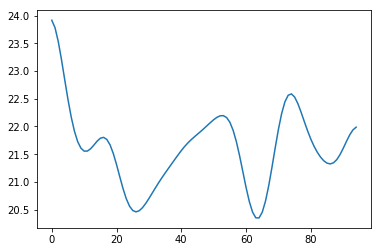

a grad norms [29.741795, 29.741581, 5.0178813e-05, 1.2761099e-12, 0.00022932055, 7.264685e-05, 8.0388224e-11, 0.00028663903]
v grad norms [3103.125, 3346.786, 2.8416218e-09, 9.982548]
c grad norms [19.170057, 16.790071, 0.15764792, 7.7586584e-08, 1.2844438e-06]
aloss 4.2946205 atype 0 closs 0.5217972 ctype 0 vloss 3.0062714 vtype 2
 ep,  110  avg frames 21.55
abs action (17,) 0.6825833627406288
max reward 8.005092263463462
a grad norms [50.453392, 50.453373, 3.807905e-05, 1.2027697e-09, 0.00027458736, 0.000294666, 7.5256225e-11, 7.789232e-05]
v grad norms [23119.852, 23533.445, 3.5282453e-09, 4.167332]
c grad norms [14.440627, 14.623034, 0.0029208714, 8.507806e-08, 4.9278333e-07]
aloss 11.135702 atype 2 closs 0.7120056 ctype 1 vloss 2.041809 vtype 1
 ep,  120  avg frames 22.25
abs action (17,) 0.5921282060444355
max reward 8.115363993380132
 ep,  130  avg frames 25.0
abs action (17,) 0.5297832445186728
max reward 8.557041385193633
a grad norms [41.22531, 41.22531, 6.981131e-05, 1.61776

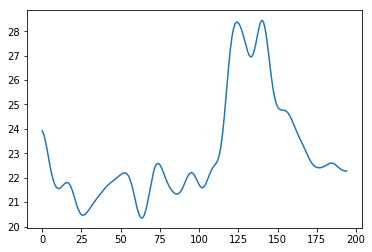

a grad norms [27.18734, 27.187529, 0.00011762165, 2.084058e-09, 0.0004031012, 0.00025172843, 6.442756e-11, 5.321668e-06]
v grad norms [1693.896, 1528.9348, 3.2310535e-10, 9.137305]
c grad norms [8.2189455, 8.195501, 5.2710453e-05, 5.0737494e-08, 6.160966e-06]
aloss 5.701462 atype 1 closs 1.4048843 ctype 2 vloss 4.4692383 vtype 2
 ep,  210  avg frames 22.3
abs action (17,) 0.30919139262507944
max reward 9.148645327613037
a grad norms [31.604557, 31.604702, 4.6908295e-05, 9.688638e-12, 0.0004074686, 5.1158746e-05, 6.1592655e-11, 2.461923e-07]
v grad norms [9813.029, 9317.678, 1.5987627e-10, 13.0642805]
c grad norms [27.812185, 20.097595, 2.1243107, 5.5229854e-08, 2.6500143e-06]
aloss 20.73717 atype 2 closs 3.2518768 ctype 2 vloss 2.5478516 vtype 0
 ep,  220  avg frames 22.3
abs action (17,) 0.2883393219398225
max reward 8.843554412650214
a grad norms [28.222202, 28.222225, 3.891946e-05, 8.8904517e-10, 0.00013547282, 0.00014100486, 6.522392e-11, 3.819876e-06]
v grad norms [46.61145, 52.53

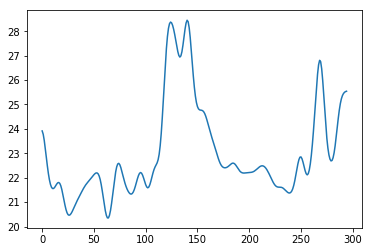

a grad norms [46.53228, 46.532394, 0.00014401168, 1.2014607e-09, 0.0004703682, 0.00017600584, 1.01588696e-10, 0.00027875663]
v grad norms [190.97133, 156.11017, 9.096205e-09, 3.7852054]
c grad norms [4.7271433, 4.732538, 0.00010183389, 4.0548034e-08, 1.6138778e-06]
aloss 6.604435 atype 1 closs 1.612957 ctype 2 vloss 0.8130188 vtype 1
 ep,  310  avg frames 25.2
abs action (17,) 0.4038718877469792
max reward 8.049641389413182
a grad norms [47.69683, 47.697094, 5.6124893e-05, 1.5370598e-09, 0.0008495739, 8.895983e-05, 1.0604449e-10, 1.1212167e-06]
v grad norms [101.830124, 111.9495, 8.61331e-09, 0.6745624]
c grad norms [2.8425474, 2.877566, 0.00032948604, 4.2542105e-08, 1.3675423e-06]
aloss 15.386955 atype 2 closs 1.4169006 ctype 2 vloss 0.37677002 vtype 0
 ep,  320  avg frames 23.75
abs action (17,) 0.2712003138354596
max reward 8.746377632677673
a grad norms [33.91796, 33.918003, 3.1487933e-05, 2.468531e-10, 0.00026520534, 0.00011210141, 9.276732e-11, 1.9992233e-06]
v grad norms [252.25

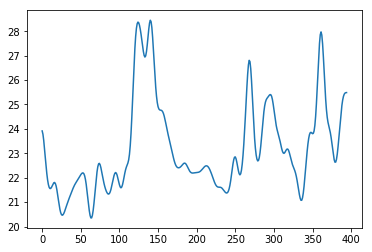

a grad norms [40.060486, 40.060566, 2.3540293e-05, 4.136617e-12, 0.0002682102, 2.3377419e-05, 7.7178375e-11, 1.733386e-05]
v grad norms [184.83815, 174.36115, 1.36913165e-08, 1.1151859]
c grad norms [7.2795353, 7.2204814, 0.0038414155, 2.955867e-08, 1.09676016e-07]
aloss 6.4905396 atype 1 closs 1.0156136 ctype 2 vloss 0.49108124 vtype 1
 ep,  410  avg frames 25.95
abs action (17,) 0.2997375572209849
max reward 8.439318467880275
a grad norms [44.58614, 44.58629, 2.6040381e-05, 6.795491e-10, 0.00036568384, 4.8066126e-05, 8.8519775e-11, 6.319555e-07]
v grad norms [168.04636, 177.82448, 9.059009e-09, 0.7949934]
c grad norms [2.772405, 2.7856197, 3.183821e-05, 3.1293993e-08, 1.4255885e-06]
aloss 8.051594 atype 1 closs 0.62304306 ctype 1 vloss 0.7203369 vtype 1
 ep,  420  avg frames 28.9
abs action (17,) 0.2496566585100749
max reward 8.410239854798885
a grad norms [29.44047, 29.440578, 1.5249027e-05, 2.0509037e-11, 0.00017316264, 5.5531913e-05, 8.872217e-11, 5.5011315e-06]
v grad norms [14.9

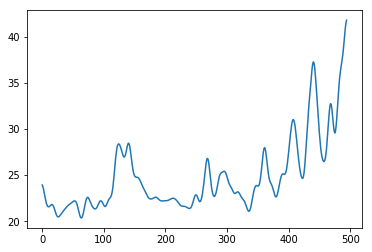

a grad norms [15.530964, 15.530984, 5.4635366e-05, 2.0419022e-12, 0.00034342622, 7.228559e-05, 1.09350036e-10, 8.4717664e-07]
v grad norms [346.73587, 377.2639, 2.5624445e-08, 3.5383642]
c grad norms [2.6975036, 2.7059367, 9.364293e-06, 4.2989942e-08, 2.196679e-09]
aloss 4.5976095 atype 1 closs 0.17919159 ctype 0 vloss 1.0472717 vtype 2
 ep,  510  avg frames 38.05
abs action (17,) 0.6845593075541889
max reward 8.629796676641842
a grad norms [18.097982, 18.09804, 2.5112335e-05, 5.704798e-10, 0.00025367984, 5.063812e-05, 1.12221045e-10, 3.2163261e-06]
v grad norms [773.80304, 709.023, 2.1437442e-08, 6.2485723]
c grad norms [65.02474, 65.23344, 0.0030824794, 4.5614296e-08, 1.3954547e-06]
aloss 4.2012873 atype 1 closs 0.5349426 ctype 0 vloss 1.2481079 vtype 2
 ep,  520  avg frames 35.0
abs action (17,) 0.5356525040822372
max reward 9.059892011903958
a grad norms [19.079842, 19.079906, 1.6478458e-05, 1.1889129e-10, 0.00015479444, 7.641967e-06, 1.189342e-10, 2.0071113e-05]
v grad norms [2032

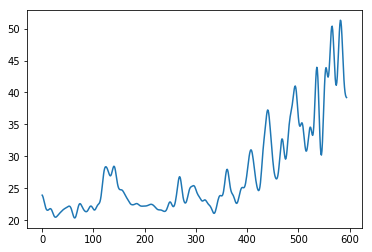

a grad norms [21.431038, 21.431324, 4.5530178e-05, 8.193525e-09, 0.0008469771, 5.057952e-05, 1.3283508e-10, 1.1135954e-05]
v grad norms [1860.6753, 1676.7797, 1.4338751e-08, 17.431698]
c grad norms [61.463814, 61.66233, 0.00023888874, 6.597884e-08, 8.856179e-08]
aloss 2.8924694 atype 0 closs 1.7628326 ctype 1 vloss 0.4309082 vtype 0
 ep,  610  avg frames 41.9
abs action (17,) 1.4533282582301303
max reward 9.295954218938732
 ep,  620  avg frames 40.0
abs action (17,) 1.4875929355621338
max reward 8.967748769294975
a grad norms [18.575432, 18.575602, 2.5123612e-05, 6.397208e-09, 0.0006250296, 4.388239e-05, 1.3607954e-10, 5.1603784e-06]
v grad norms [15291.332, 15509.301, 1.923868e-08, 9.538986]
c grad norms [8.389031, 8.408656, 0.0003021249, 8.603675e-08, 1.5076994e-08]
aloss 4.5174217 atype 1 closs 0.2811432 ctype 0 vloss 2.741333 vtype 1
 ep,  630  avg frames 45.75
abs action (17,) 0.8095521120464101
max reward 9.170063424718364
a grad norms [10.654095, 10.6542845, 2.2673188e-05, 1.408

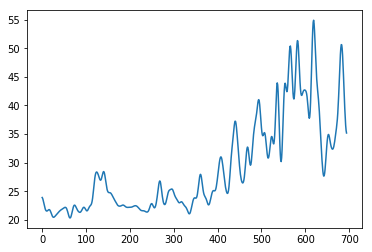

a grad norms [14.753876, 14.754185, 2.1112493e-05, 7.3208073e-10, 0.00060574565, 2.2294133e-05, 1.3468873e-10, 8.2471166e-07]
v grad norms [1234.0896, 1347.3007, 1.5316584e-08, 9.845645]
c grad norms [14.887371, 14.927142, 3.4498207e-05, 1.16428915e-07, 4.4961165e-08]
aloss 6.1851053 atype 2 closs 0.9306717 ctype 2 vloss 1.4929199 vtype 2
 ep,  710  avg frames 43.6
abs action (17,) 1.6713678065468283
max reward 9.501345114087325
a grad norms [19.681871, 19.682152, 2.5812571e-05, 7.2743394e-09, 0.002212445, 6.22793e-05, 1.3950399e-10, 1.7497031e-06]
v grad norms [17205.771, 16296.603, 1.4130801e-08, 36.492702]
c grad norms [67.0806, 67.29249, 0.00024812526, 1.15508065e-07, 2.9793463e-09]
aloss 4.870432 atype 2 closs 1.4708557 ctype 2 vloss 0.35125732 vtype 0
 ep,  720  avg frames 44.95
abs action (17,) 1.6970019270392025
max reward 8.76105450295795
a grad norms [27.864431, 27.86487, 2.2962586e-05, 3.1690865e-09, 0.00076806557, 1.4863871e-05, 1.3636713e-10, 1.7457365e-05]
v grad norms [7

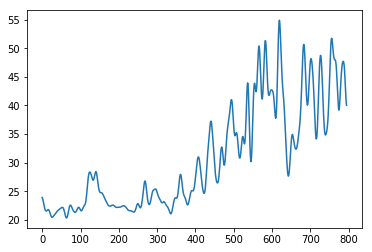

a grad norms [22.538492, 22.539364, 2.0599211e-05, 3.3290486e-09, 0.0017970088, 3.9024446e-05, 1.4854963e-10, 5.1901583e-08]
v grad norms [406.71518, 310.33664, 1.2559081e-08, 18.36087]
c grad norms [5.1812444, 5.20913, 0.000104795894, 1.6326803e-07, 1.0990237e-08]
aloss 7.0740786 atype 2 closs 0.9574585 ctype 2 vloss 0.41577148 vtype 0
 ep,  810  avg frames 46.75
abs action (17,) 1.659992547596202
max reward 9.384974056757802
a grad norms [30.39754, 30.398756, 4.5539673e-05, 9.72906e-09, 0.002530706, 3.369353e-05, 1.4608766e-10, 2.8696282e-05]
v grad norms [5058.98, 4621.0254, 1.3573786e-08, 40.570107]
c grad norms [16.688574, 16.778091, 0.00013662658, 1.567847e-07, 1.0265274e-08]
aloss 4.9138737 atype 2 closs 1.3636017 ctype 1 vloss 1.2098083 vtype 2
 ep,  820  avg frames 54.4
abs action (17,) 1.456557067001567
max reward 9.051593266104874
a grad norms [30.807302, 30.808916, 4.1267376e-05, 1.2764842e-08, 0.0028403, 2.7263146e-05, 1.5152837e-10, 4.2837616e-08]
v grad norms [2753.6697,

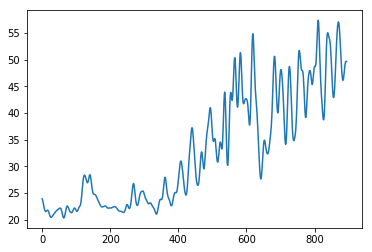

a grad norms [26.161629, 26.16224, 1.8369426e-05, 4.2648263e-09, 0.0012929756, 2.8207112e-05, 1.6904093e-10, 8.853857e-07]
v grad norms [14996.941, 15478.92, 1.9728807e-08, 26.593185]
c grad norms [9.410176, 9.434738, 2.6638645e-05, 1.876166e-07, 3.2155756e-09]
aloss 1.6182108 atype 0 closs 0.2059021 ctype 0 vloss 0.4967041 vtype 0
 ep,  910  avg frames 46.65
abs action (17,) 1.3849463077152477
max reward 8.650473182174517
a grad norms [22.237276, 22.237955, 2.1093714e-05, 3.854668e-09, 0.0014683043, 2.9063705e-05, 1.7531142e-10, 2.8082047e-07]
v grad norms [37.04782, 74.490425, 2.0718229e-08, 15.860004]
c grad norms [5.2548776, 5.2723165, 1.8173569e-05, 1.9933607e-07, 4.6817866e-10]
aloss 4.7055054 atype 2 closs 0.48873138 ctype 2 vloss 1.1569214 vtype 2
 ep,  920  avg frames 38.65
abs action (17,) 1.417002194068011
max reward 7.694854525159849
a grad norms [20.464748, 20.465427, 1.5501808e-05, 6.300722e-10, 0.0013907974, 1.9789977e-05, 1.7021604e-10, 4.6352417e-07]
v grad norms [135.

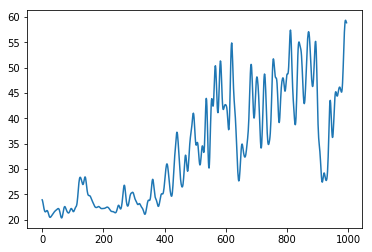

a grad norms [20.59044, 20.590347, 1.9054944e-05, 3.3947987e-09, 0.0023824829, 6.3175234e-05, 1.723914e-10, 3.7563845e-07]
v grad norms [9195.645, 8830.325, 2.0894571e-08, 28.178583]
c grad norms [12.589577, 12.647075, 7.4793395e-05, 2.0815087e-07, 4.2334736e-09]
aloss 1.8632574 atype 0 closs 0.6124649 ctype 2 vloss 0.26846313 vtype 0
 ep,  1010  avg frames 49.25
abs action (17,) 0.007717004380020627
max reward 8.961610808137811
a grad norms [29.89087, 29.891659, 3.881265e-05, 1.4160954e-08, 0.002769244, 6.856556e-05, 1.7279429e-10, 1.8311347e-07]
v grad norms [585.7414, 514.2563, 2.1016012e-08, 35.99686]
c grad norms [10.8954, 10.950148, 8.035833e-05, 2.0751526e-07, 8.799936e-10]
aloss 7.82283 atype 1 closs 0.9963074 ctype 1 vloss 0.29016113 vtype 0
 ep,  1020  avg frames 41.4
abs action (17,) 0.9329436581362697
max reward 9.453059924124727
a grad norms [18.832012, 18.832905, 1.41446735e-05, 6.3780015e-10, 0.0012271487, 1.1652998e-05, 1.728123e-10, 6.290846e-08]
v grad norms [654.5696

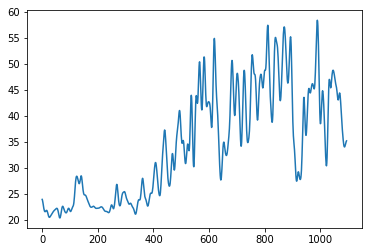

a grad norms [20.378828, 20.379662, 1.6896698e-05, 3.2511922e-09, 0.0023031335, 1.687599e-05, 1.8631838e-10, 3.4369933e-08]
v grad norms [54488.2, 53456.406, 1.40385055e-08, 25.706278]
c grad norms [15.745375, 15.831293, 0.00013144797, 2.3470744e-07, 1.8733832e-09]
aloss 1.9273853 atype 0 closs 0.66960907 ctype 2 vloss 0.33764648 vtype 0
 ep,  1110  avg frames 34.4
abs action (17,) 0.45727111662135406
max reward 8.445490512635581
a grad norms [30.645922, 30.648153, 3.4187775e-05, 1.0444376e-08, 0.003847888, 3.5443525e-05, 1.8647646e-10, 2.042982e-08]
v grad norms [3442.118, 3810.788, 1.4729912e-08, 52.053833]
c grad norms [14.9431095, 15.036406, 0.00015816008, 2.3751785e-07, 5.0956044e-09]
aloss 1.8464088 atype 0 closs 0.6300278 ctype 2 vloss 2.340088 vtype 1
 ep,  1120  avg frames 40.15
abs action (17,) 0.926014244556427
max reward 9.002702550053618
a grad norms [37.437363, 37.440414, 4.4112818e-05, 1.857954e-08, 0.0047701895, 6.0829432e-05, 1.862861e-10, 1.00179236e-07]
v grad norms 

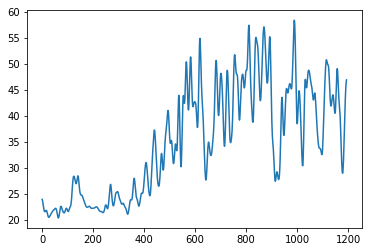

a grad norms [40.104923, 40.106888, 3.7933773e-05, 7.937861e-09, 0.004926343, 4.772811e-05, 1.8038124e-10, 3.6755247e-07]
v grad norms [30264.5, 29554.492, 1.5819852e-08, 45.55337]
c grad norms [28.899136, 29.099236, 0.00038036573, 2.6092857e-07, 5.4353104e-09]
aloss 5.309376 atype 2 closs 1.3302612 ctype 1 vloss 1.1939087 vtype 2
 ep,  1210  avg frames 54.25
abs action (17,) 0.6106590242946849
max reward 8.934171101236302
a grad norms [25.249498, 25.251305, 2.4701916e-05, 3.8377324e-09, 0.0033399304, 2.7378575e-05, 1.8103306e-10, 1.3619785e-07]
v grad norms [13650.347, 13848.541, 1.6302069e-08, 39.793793]
c grad norms [6.8942647, 6.931304, 6.0666094e-05, 2.6325543e-07, 3.6911862e-09]
aloss 7.779007 atype 1 closs 0.20261383 ctype 0 vloss 0.32373047 vtype 0
 ep,  1220  avg frames 49.0
abs action (17,) 1.1249156734522652
max reward 9.416590524868479


KeyboardInterrupt: 

In [ ]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, mh, rh, rdecayedh, maskh, ep, globalframes = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-1000:], sh[-1000:], mh[-1000:],
                 rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
                ], f)
    trained = 1
    ongoing = 1
    an, sn = [np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS]]
    mn, rn, maskn = [], [], []
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obs = np.concatenate((obs, np.zeros((N_ACT + 1))))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    done_ctr = 0
    metaobs = .00
    mn.append(metaobs)
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    while 1:
        prob_random = .95#1 - 1/np.sqrt(ep+1)
        step_num += 1
        a = pi.act(obs_mat.flatten(), metaobs, env)
        if step_shifted == -1: #always act on your own
            shifted = 1
            if np.random.rand() > prob_random:
                a = np.random.randn(*a.shape)*.01
            elif np.random.rand() > prob_random:
                a = a + np.random.randn(*a.shape) * .5
                #a = a + np.random.randn(*a.shape)/np.sqrt(np.sqrt(ep + 2))*4
            elif np.random.rand() > prob_random:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2
                if np.random.rand() > .5:
                    a = a + impact
                else:
                    a = a - impact
            elif np.random.rand() > prob_random:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2 - 1
                a = a + impact
            elif np.random.rand() > prob_random:
                a = a * .5
            elif np.random.rand() > prob_random:
                a = a * 2
            else:
                shifted = 0
            if shifted:
                step_shifted = step_num
            t = a
#         else:
#             if step_shifted > -1:
#                 if not show_shift:
#                     show_shift = 1
#                     print('step_shifted', step_shifted)
        an = np.concatenate((an, a[None,:]), 0)
        last_obs = obs
        obs, r, done, _ = env.step(a)
        r = r + 8
        obs = np.concatenate((obs, a, np.array([r])))
        obs = np.concatenate((obs, obs - last_obs[:last_obs.shape[0]//2]))
        obs_mat = np.concatenate((obs[None,:], obs_mat[:-1,:]/1.3), 0)
        metaobs = metaobs + .01
        mn.append(metaobs)
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        still_open = env.render("human")
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    mn = np.array(mn)
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, mh, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, mn, rn,rdecayedn, maskn]]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh = [get_updated_h(h, n, 1) for  h, n in zip([ah, sh], [an, sn])]
        
        mh, rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [mh, rh, rdecayedh, maskh], [mn, rn, rdecayedn, maskn])]
        
    if ep % 1 == 0 and ep > 5:
        ah, sh, mh, rh,rdecayedh, maskh = [
            v[-400:] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 16
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        total_aloss = 0
        total_closs = 0
        for itr in range(1):
            if num_hist >  batch_size:
                forced_hist = 2
                #probability = np.arange(num_hist - forced_hist)
                probability = num_steps_per_run = (
                    maskh.shape[1] - maskh[:,::-1].argmax(1))[:-forced_hist]
                probability = np.square(probability)
                probability = probability / probability.sum()
                samples = np.concatenate((
                    np.random.choice(
                        num_hist - forced_hist, batch_size - forced_hist, 
                        replace=False, p=probability),
                    np.arange(
                        num_hist - forced_hist, num_hist)))
            else:
                samples = np.random.choice(num_hist, num_hist, replace=False)
            actions, states, meta, returns, returnsdecayed, mask = [
                v[samples] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
            feed_dict={
                        self.metaobs:meta[:,:,None],
                        self.returns:returns,
                        self.returnsdecayed:returnsdecayed,
                        self.lr: .02 / np.power(ep + 30, .5),
                        self.mask:mask}
            if ADV_ENABLED:
                adv_sample = np.random.rand() > .1
            else:
                adv_sample = 0
            if adv_sample:
                a_type = np.random.choice(3)
                feed_dict[self.obs] = states
                a_obs_grad, aloss_pre = sess.run(
                    [self.a_obs_grad, self.a_loss], feed_dict)
                a_obs_grad = normalize_adv(a_obs_grad[0], mag = 3, adv_type = a_type)
                feed_dict[self.obs] = states + a_obs_grad
            else:
                feed_dict[self.obs] = states + np.random.rand(*states.shape) * .1
            _, aloss = sess.run(
                [self.aopt, self.a_loss],
                feed_dict = feed_dict
                    )
            if TESTING_GRAD_NORMS and ep % printfreq == 0 and adv_sample:
                a_grad_norms = self.sess.run(self.a_grads, feed_dict)
                print('a grad norms', a_grad_norms)
            if adv_sample:
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
            else:
                feed_dict[self.pi] = actions + np.random.rand(*actions.shape) * .1
                feed_dict[self.obs] = states[:,:-1,:] + np.random.rand(
                    *states[:,:-1,:].shape) * .1
            feed_dict[self.metaobs] = meta[:,:-1,None]
            feed_dict[self.returns] = returns[:,:-1]
            feed_dict[self.returnsdecayed] = returnsdecayed[:,:-1]
            feed_dict[self.mask] = mask[:,:-1]
            if adv_sample:
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
                v_obs_grad, vloss_pre = sess.run(
                    [self.v_obs_grad, self.v_loss], feed_dict)
                v_type = np.random.choice(3)
                v_obs_grad = normalize_adv(v_obs_grad[0], mag = .1, adv_type = v_type)
                feed_dict[self.obs] = states[:,:-1,:] + v_obs_grad
                _, vloss = sess.run(
                    [self.vopt, self.v_loss],
                        feed_dict=feed_dict)
                if TESTING_GRAD_NORMS and ep % printfreq == 0:
                    v_grad_norms = self.sess.run(self.v_grads, feed_dict)
                    print('v grad norms', v_grad_norms)
                
                feed_dict[self.pi] = actions
                feed_dict[self.obs] = states[:,:-1,:]
                c_obs_grad, c_pi_grad, closs_pre = sess.run(
                    [self.c_obs_grad, self.c_pi_grad, self.c_loss], feed_dict)
                c_type = np.random.choice(3)
                c_obs_grad, c_pi_grad = [
                    normalize_adv(v[0], mag = .1, adv_type = c_type) 
                    for v in [c_obs_grad, c_pi_grad]]
                feed_dict[self.pi] = actions + c_pi_grad
                feed_dict[self.obs] = states[:,:-1,:] + c_obs_grad
                
                _,closs = sess.run(
                    [self.copt, self.c_loss],
                        feed_dict=feed_dict)
                if TESTING_GRAD_NORMS and ep % printfreq == 0:
                    c_grad_norms = self.sess.run(self.c_grads, feed_dict)
                    print('c grad norms', c_grad_norms)
                
            else:
                _,_, closs, vloss = sess.run(
                    [self.copt,self.vopt, self.c_loss, self.v_loss],
                        feed_dict=feed_dict)
            if 0:
                if ep % printfreq == 0:('aloss', aloss, 'closs', closs, 'vloss', vloss)
        if ep % printfreq == 0:
            if adv_sample:
                print('aloss', aloss - aloss_pre, 'atype', a_type,
                      'closs', closs - closs_pre,  'ctype', c_type,
                      'vloss', vloss - vloss_pre,  'vtype', v_type,)
            print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
            print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
            print('max reward',np.max(rh[-10:,10:]))
        if ep % 10000 == 0:
            clear_output()
        if ep % 100 == 0:
            ysmoothed = gaussian_filter1d(globalframes, sigma=4)
            plt.plot(ysmoothed)
            plt.show()


In [ ]:
rdecayedh[-2]

In [ ]:
sess.run(self.pi, feed_dict).max()

In [ ]:
ah[-1]

In [ ]:
samples = np.arange(
            num_hist - 4, num_hist)
actions, states, meta, returns, returnsdecayed, mask = [
    v[samples] for v in [ah, sh, mh, rh,rdecayedh, maskh]]
feed_dict={
            self.metaobs:meta[:,:,None],
            self.returns:returns,
            self.returnsdecayed:returnsdecayed,
            self.lr: .01 / np.power(ep + 10, .7),
            self.mask:mask,
            self.obs:states}

In [ ]:
# sess.run(tf.global_variables_initializer())

In [ ]:
# self.sess.run(self.pi, feed_dict)[3]

In [ ]:
ah[-4].std()

In [ ]:
self.sess.run(self.actstdpenalty, feed_dict)

In [ ]:
ah[-8].std()

In [ ]:
self.sess.run(self.pi, feed_dict)[-4]

In [ ]:

            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.aregmagnitude, 
                self.aregmean,self.aregmeanbyaction,
                self.actstdpenalty, self.areg, self.grad_norm_a
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.grad_c_close_1, self.creg, self.grad_norm_c
            ]]
        

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

ysmoothed = gaussian_filter1d(globalframes, sigma=4)
plt.plot(ysmoothed)

In [ ]:

save_path = saver.save(sess, tffile)
print('saved at epoch', ep)
with open(obj_fname,"wb") as f:
    pickle.dump(
        [ah[-1000:], sh[-1000:], mh[-1000:],
         rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
        ], f)
trained = 1

In [ ]:
# rdecayedh[-2][np.where(mask[2])]

# sess.run(self.state_value_estimate,feed_dict)[2][np.where(mask[2])]

In [ ]:
# sess.run(self.state_value_estimate,feed_dict)[1][np.where(mask[1])].shape

# sess.run(self.state_value_estimate,feed_dict)[1][np.where(mask[1])]

In [ ]:
ah[-2][:5].round(2)